In [2]:
# Import libraries
%matplotlib inline
import numpy as np
import pandas as pd
import csv
from collections import Counter
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from matplotlib import pyplot
import random
from datetime import datetime, timedelta
from pickle import dump, load

In [3]:
# Importa os dados
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataset = pd.read_csv(url, names=names)

In [4]:
# Distribuição da variável target
print(Counter(dataset['class']))

Counter({0: 500, 1: 268})


In [5]:
# Encontra colunas com valores ausentes e apresenta um resumo da base
columnsDF = pd.DataFrame(dataset.isnull().any(), columns = np.array(['hasMissing']))
print(columnsDF.query('hasMissing == True'))

# Encontra as linhas com algum valor ausente
null_data = dataset[dataset.isnull().any(axis=1)]
print(null_data.shape[0])

# Elimina as observações com valores ausentes
datasetFiltered = dataset.dropna()

Empty DataFrame
Columns: [hasMissing]
Index: []
0


In [6]:
# Extrai a variável target para uma variável específica e a elimina da base 
target = datasetFiltered['class']
datasetFiltered = datasetFiltered.drop('class', 1)

In [7]:
# Estatística descritiva
datasetFiltered.describe()

,preg,plas,pres,skin,test,mass,pedi,age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


In [9]:
# Configura alguns parâmetros
seed = 7
scoring = 'recall'
test_size = 0.25
n_splits = 10
kfold = KFold(n_splits=n_splits, random_state=seed) 

In [11]:
# Separa a base entre treino e teste de forma aleatória
X = datasetFiltered.values
Y = target
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size)

ADA: 0.545699 (0.107619)
GB: 0.572563 (0.107671)
RF: 0.491450 (0.067753)
CART: 0.577198 (0.092015)


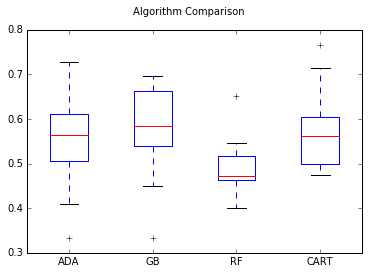

In [27]:
# Prepara os algoritmos 
models = [] 
models.append(('ADA', AdaBoostClassifier())) 
models.append(('GB', GradientBoostingClassifier())) 
models.append(('RF', RandomForestClassifier())) 
models.append(('CART', DecisionTreeClassifier())) 
#models.append(('SVM', SVC()))

# Avalia os algoritmos
results = [] 
names = [] 

for name, model in models: 
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring) 
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()) 
    print(msg)

# Compara os algoritmos
fig = pyplot.figure() 
fig.suptitle('Algorithm Comparison') 
ax = fig.add_subplot(111) 
pyplot.boxplot(results) 
ax.set_xticklabels(names) 
pyplot.show()

In [28]:
# Cria o modelo base com o melhor algoritmo
baseline = DecisionTreeClassifier(random_state = seed)
baseline.fit(X_train, Y_train)

# Verifica a impostância de cada variável no modelo
featureName = pd.DataFrame(datasetFiltered.columns, columns=['Feature'])
featureImp = pd.DataFrame(baseline.feature_importances_, columns=['Imp'])
pd.concat([featureName, featureImp], axis=1)

,Feature,Imp
0,preg,0.038493
1,plas,0.302841
2,pres,0.029082
3,skin,0.044992
4,test,0.023494
5,mass,0.225033
6,pedi,0.217690
7,age,0.118375


In [29]:
# Testa contra os dados de teste
predictions = baseline.predict(X_test)
print(confusion_matrix(Y_test, predictions))
print(classification_report(Y_test, predictions))

[[93 30]
 [37 32]]
             precision    recall  f1-score   support

          0       0.72      0.76      0.74       123
          1       0.52      0.46      0.49        69

avg / total       0.64      0.65      0.65       192



In [15]:
# Salva o modelo em disco
filename = 'binary_class_model.sav' 
dump(baseline, open(filename, 'wb'))

# load the model from disk 
#loaded_model = load(open(filename, 'rb')) 
#result = loaded_model.score(X_test, Y_test) 
#print(result)# Create the final model